# QA sur document PDF avec LangChain & Hugging Face
Ce notebook présente un use case de QA traité avec Langchain. LangChain, un framework open-source, qui permet de construire facilement des applications. Ce notebook explique pas à pas, les étapes pour construire cette application. L'idée est la suivante : on effectue de la recherche par similarité entre l'embedding de la question (input) et des morceaux de textes du document, afin d'identifier où la réponse semble se trouver. Enfin, on fournit au LLM la question ainsi que les informations dont on dispose (les morceaux de textes pertinants), pour avoir une réponse claire en language naturel.

Etapes clés :
1. Import du modèle
2. Chargement & processing des documents
3. HF Embeddings
4. Creation de la Vector DB
5. Creation de retriever
6. Creation de la chain

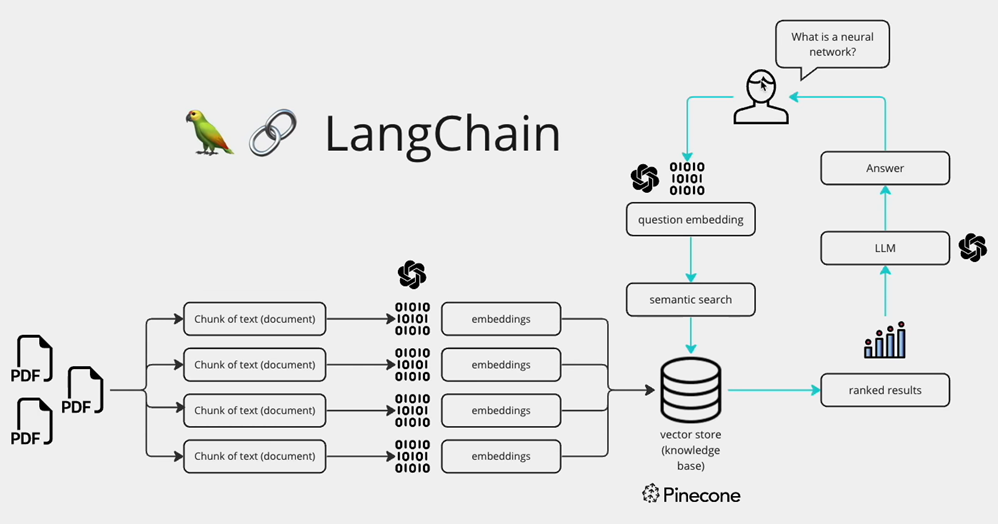

Sources


*   https://python.langchain.com/docs/modules/chains/popular/vector_db_qa.html
*   https://github.com/gkamradt/langchain-tutorials/blob/main/LangChain%20Cookbook%20Part%202%20-%20Use%20Cases.ipynb

## import

In [ ]:
!pip -q install langchain tiktoken chromadb pypdf transformers InstructorEmbedding sentence_transformers
!pip -q install accelerate bitsandbytes sentencepiece Xformers

In [ ]:
!pip show langchain

Name: langchain
Version: 0.0.229
Summary: Building applications with LLMs through composability
Home-page: https://www.github.com/hwchase17/langchain
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, async-timeout, dataclasses-json, langchainplus-sdk, numexpr, numpy, openapi-schema-pydantic, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: 


## 1. Import du modèle
Import du LLM, la brique élémentaire de notre application. Téléchargement via hugging face, le LLM tourne le local.



In [ ]:
import torch
import transformers
from transformers import GenerationConfig, pipeline, AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bigscience/bloomz-560m") #3b 1b1 560m
model = AutoModelForCausalLM.from_pretrained("bigscience/bloomz-560m",load_in_8bit=True, device_map='auto', torch_dtype=torch.float16, low_cpu_mem_usage=True)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//172.28.0.1'), PosixPath('http'), PosixPath('8013')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --

Avec `HuggingFacePipeline` de `langchain.llms`, on peut inférer facilement un LLM.

In [ ]:
from transformers import pipeline
from langchain.llms import HuggingFacePipeline
import torch

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
   # min_length=10,
    max_length=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15
)

local_llm = HuggingFacePipeline(pipeline=pipe)

Quelques questions d'échauffement.

In [ ]:
print(local_llm('What is the capital of France ?'))

 Paris


In [ ]:
print(local_llm('Which day comes after friday ?'))

 Saturday


In [ ]:
print(local_llm('What is the color of the sky ?'))

 blue


# LangChain multi-doc retriever with ChromaDB

***New Points***
- Multiple Files - PDFs
- ChromaDB : Chroma is the open-source embedding database. Chroma makes it easy to build LLM apps by making knowledge, facts, and skills pluggable for LLMs.
- Local LLM
- Instuctor Embeddings


## Setting up LangChain


In [ ]:
import os

In [ ]:
from langchain.vectorstores import Chroma # pour stocker les embeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter # pour découper les documents en morceau

from langchain.chains import RetrievalQA # chaine de Q/A
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader

from langchain.embeddings import HuggingFaceInstructEmbeddings # charger le modèle d'embedding

## 2. Chargement & processing des documents
Lecture des fichiers .pdf ou .txt avec `TextLoader` `PyPDFLoader` `DirectoryLoader`. Ici le fichier est stocké dans le dossier /documents/.


In [ ]:
# Load and process the text files

# Pour un seul fichier
# loader = TextLoader('attention.txt')

loader = DirectoryLoader('./documents/', glob="./*.pdf", loader_cls=PyPDFLoader)

documents = loader.load()

In [ ]:
len(documents)

40

Les documents sont coupés dans un premier temps pages par pages. Les metadata permettent de connaitre la source (chemin) et la page précise.

In [ ]:
documents[0]

Document(page_content="1 janvier2015\nC O N S T I T U T I O N\nLe Gouvernement de la République, conformément\nàla loi constitutionnelledu 3juin 1958,a proposé,\nLepeuplefrançais aadopté,\nLe Président de la République promulgue la loi\nconstitutionnelledontlateneursuit:\nPRÉAMBULE\nLe peuple français proclame solennellement son attachement aux Droits de\nl'homme et aux principes delasouveraineté nationaletels qu'ils ont été définis parla\nDéclaration de 1789, confirmée et complétée par le préambule de la Constitution de\n1946, ainsi qu'aux droits et devoirs définis dans la Charte de l'environnement de\n2004.\nEn vertu de ces principes et de celui de la libre détermination des peuples, la\nRépublique offre aux territoires d'outre-mer qui manifestent la volonté d'y adhérer\ndes institutions nouvelles fondées sur l'idéal commun de liberté, d'égalité et de\nfraternitéet conçuesen vuedeleurévolutiondémocratique.\n________\nARTICLE PREMIER . La France est une République indivisible, laïque,

On découpe les documents en morceaux. Il existe plusieurs méthodes `RecursiveCharacterTextSplitter`, `CharacterTextSplitter`. Dans chacun de ses morceaux de textes, on peut retrouver le document et la page d'origine.

In [ ]:
#splitting the text into (CharacterTextSplitter)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, # controls the max size (in terms of number of characters) of the final documents
                                               chunk_overlap=200 # specifies how much overlap there should be between chunks.
                                              )
texts = text_splitter.split_documents(documents)

In [ ]:
len(texts)

222

On passe d'un document à 40 pages à 222 morceaux de ce document.

In [ ]:
texts[0]

Document(page_content="1 janvier2015\nC O N S T I T U T I O N\nLe Gouvernement de la République, conformément\nàla loi constitutionnelledu 3juin 1958,a proposé,\nLepeuplefrançais aadopté,\nLe Président de la République promulgue la loi\nconstitutionnelledontlateneursuit:\nPRÉAMBULE\nLe peuple français proclame solennellement son attachement aux Droits de\nl'homme et aux principes delasouveraineté nationaletels qu'ils ont été définis parla\nDéclaration de 1789, confirmée et complétée par le préambule de la Constitution de", metadata={'source': 'documents/constitution.pdf', 'page': 0})

## 3. HF Embeddings

Un point cléf dans la recherche sémantique est l'embedding des morceaux de document. Ici on import un modèle (transformer-encoder) depuis hugging face. A la manière de Open Leaderboard LLM, qui classe les LLMs (decoder),
[Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard) classe les modèles d'embeddings.

On choisit e5-small-v2 qui génère des embeddings de dimension 768. Attention à la longueur max en entrée.



In [ ]:
from langchain.embeddings import HuggingFaceInstructEmbeddings

instructor_embeddings = HuggingFaceInstructEmbeddings(model_name="ggrn/e5-small-v2", #hkunlp/instructor-xl
                                                      model_kwargs={"device": "cuda"})

load INSTRUCTOR_Transformer
max_seq_length  512


## 4. Creation de la Vector DB
Maintenant que nous avons découpé notre document en morceaux et importé notre modèle d'embedding, on peut générer les morceaux de textes sous forme d'embedding (représentation vectorielle) dans notre base de donnée.

On utilise ici la solution Chroma (framework).

In [ ]:
# Embed and store the texts
# Supplying a persist_directory will store the embeddings on disk
persist_directory = 'db'

## Here is the nmew embeddings being used
embedding = instructor_embeddings

vectordb = Chroma.from_documents(documents=texts,
                                 embedding=embedding,
                                 persist_directory=persist_directory)

## 5. Création du retriever
On indique, lors de la recherche par similarité (entre l'embedding de la question et embeddings de la database), comment choisir les meilleurs résultats : ici les 3 meilleurs. La recherche par similarité utilise le calcul du cosinus entre embeddings.

In [ ]:
# Récupération : les k=3 résultats les plus similaires.
retriever = vectordb.as_retriever(search_kwargs={"k": 3})

In [ ]:
#  An index is a data structure that supports efficient searching, and a retriever is the component that uses the index to find and return relevant documents in response to a user's query.
# The index is a key component that the retriever relies on to perform its function.
retriever

VectorStoreRetriever(vectorstore=<langchain.vectorstores.chroma.Chroma object at 0x7fb650350460>, search_type='similarity', search_kwargs={'k': 3})

## 6. Création de la chain
Enfin, tous les éléments sont créés. Il ne reste plus qu'à créer la chaîne. La méthode _stuff_ est utilisée : la plus simple où l'on met dans le prompt les morceaux de textes reliés à la question.

Pros: Only makes a single call to the LLM. When generating text, the LLM has access to all the data at once.

Cons: Most LLMs have a context length, and for large documents (or many documents) this will not work as it will result in a prompt larger than the context length.

The main downside of this method is that it only works on smaller pieces of data. Once you are working with many pieces of data, this approach is no longer feasible. The next two approaches are designed to help deal with that.

In [ ]:
# create the chain to answer questions
qa_chain = RetrievalQA.from_chain_type(llm=local_llm,
                                  chain_type="stuff",
                                  retriever=retriever,
                                  return_source_documents=True)

Element supplémentaire pour mettre en forme l'output.

In [ ]:
## Cite sources

import textwrap

def wrap_text_preserve_newlines(text, width=110):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['result']))
    print('\n\nSources:')
    for source in llm_response["source_documents"]:
        print(source.metadata['source'])

### Résultats
On affiche dans un premier temps la réponse donné par la chaîne puis celle du LLM sans le document. On affiche la réponse de la chaîne avec ses sources.

In [ ]:
# full example
query = "Combien de temps est élu le président ?"
llm_response = qa_chain(query)
process_llm_response(llm_response)
local_llm(query)

 5 ans


Sources:
documents/constitution.pdf
documents/constitution.pdf
documents/constitution.pdf


' one year'

In [ ]:
# full example
query = "Qui peut dissoudre l\'assembler nationale ?"
llm_response = qa_chain(query)
process_llm_response(llm_response)
local_llm(query)

 le président


Sources:
documents/constitution.pdf
documents/constitution.pdf
documents/constitution.pdf


' le roi'

In [ ]:
# full example
query = "Qui a écrit la constitution ?"
llm_response = qa_chain(query)
process_llm_response(llm_response)
local_llm(query)

 le peuple


Sources:
documents/constitution.pdf
documents/constitution.pdf
documents/constitution.pdf


' les membres du parlement'

In [ ]:
# full example
query = "Explique l'article 5"
llm_response = qa_chain(query)
process_llm_response(llm_response)
local_llm(query)

 lorsque la réalisation d'un dommage


Sources:
documents/constitution.pdf
documents/constitution.pdf
documents/constitution.pdf


' of the Constitution'

Réponse brute de la chaîne :

In [ ]:
llm_response

{'query': "Explique l'article 5",
 'result': " lorsque la réalisation d'un dommage",
 'source_documents': [Document(page_content="ARTICLE 5. Lorsque la réalisation d'un dommage, bien qu'incertaine en l'état des\nconnaissances scientifiques, pourrait affecter de manière grave et irréversible\nl'environnement, les autorités publiques veillent, par application du principe de\n34", metadata={'source': 'documents/constitution.pdf', 'page': 33}),
  Document(page_content="membre du Gouvernement dans l'exercice de ses fonctions peut porter plainte\nauprèsd'unecommission des requêtes.\n23", metadata={'source': 'documents/constitution.pdf', 'page': 22}),
  Document(page_content="l'exercice de tout mandat parlementaire, de toute fonction de représentation\nprofessionnelle à caractère national et de tout emploi public ou de toute activité\nprofessionnelle.\nUne loi organique fixe les conditions dans lesquelles il est pourvu au\nremplacement destitulaires detels mandats,fonctionsou emplois.\n7", me

In [ ]:
# full example
query = "Quand a été écrit la constitution francaise ?" # pas dans le texte La première constitution écrite fut celle de 1791, adoptée pendant la Révolution française.
llm_response = qa_chain(query)
process_llm_response(llm_response)
local_llm(query)

 1791


Sources:
documents/constitution.pdf
documents/constitution.pdf
documents/constitution.pdf


' 1791'

In [ ]:
# full example
query = "Quand a été écrite la constitution ?" # La Constitution française a été écrite pour la première fois en 1958.
llm_response = qa_chain(query)
process_llm_response(llm_response)
local_llm(query)

 1958


Sources:
documents/constitution.pdf
documents/constitution.pdf
documents/constitution.pdf


' 1949'

Voici le prompt utilisé (inclu dans LangChain) pour ce use case.

In [ ]:
print(qa_chain.combine_documents_chain.llm_chain.prompt.template)

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Helpful Answer:


In [ ]:
# full example
query = "Who is the president of the USA ?"
llm_response = qa_chain(query)
process_llm_response(llm_response)
local_llm(query)

 Barack Obama


Sources:
documents/constitution.pdf
documents/constitution.pdf
documents/constitution.pdf


' Barack Obama'

Possibilité de modifier le prompt, pour le mettre en français notamment.

In [ ]:
from langchain.prompts import PromptTemplate
prompt_template ="""Utilisez les éléments de contexte suivants pour répondre à la question finale. Si vous ne connaissez pas la réponse, dites simplement que vous ne savez pas, n'essayez pas d'inventer une réponse.

{context}

Question : {question}
Réponse utile :
"""
PROMPT = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"]
)

In [ ]:
chain_type_kwargs = {"prompt": PROMPT}
qa = RetrievalQA.from_chain_type(llm=local_llm, chain_type="stuff", retriever=retriever, chain_type_kwargs=chain_type_kwargs)

In [ ]:
qa.run('Qui est Macron ?')

'Le président de la république française'

Test avec un autre document .txt.

In [ ]:
process_llm_response(qa_chain(prompt.format(subject='transformer')))

 A model architecture eschewing recurrence and instead relying entirely on an attention mechanism


Sources:
attention.txt
attention.txt
attention.txt


In [ ]:
query = "Who wrote this article?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

 Jakob


Sources:
attention.txt
attention.txt
attention.txt


In [ ]:
query = prompt.format(subject='encodeur')
llm_response = qa_chain(query)
process_llm_response(llm_response)

 Self-attention


Sources:
attention.txt
attention.txt
attention.txt


Dans le prompt, il est demandé d'utiliser uniquement les informations fournis dans le contexte, et donc de ne pas répondre lorsque l'information ne s'y trouve pas.

In [ ]:
query = "What is multi-head attention?"
llm_response = qa_chain(query)
process_llm_response(llm_response)

 Answer not in context


Sources:
attention.txt
attention.txt
attention.txt


In [ ]:
query = "Explain positional encoding."
llm_response = qa_chain(query)
process_llm_response(llm_response)

In [ ]:
qa_chain.retriever.search_type , qa_chain.retriever.vectorstore

('similarity', <langchain.vectorstores.chroma.Chroma at 0x7fb650350460>)